In [29]:
import pandas as pd
from tqdm.auto import tqdm
# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager as fm, rc

# 한글 폰트 설정
font_path = '/usr/local/src/python3.10/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/KoPub Dotum Medium.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

In [3]:
df = pd.read_csv('mn_log_20250827.csv')

df['another_key'] = df['user_key'] + '_' + df['first_access_dt'].astype(str)
df['simple_user_id'], unique_ids = pd.factorize(df['another_key'])

tmp = df.drop(columns=['id','user_key','another_key','dept','grade','user_id']).set_index('simple_user_id')
tmp.reset_index(inplace=True)
tmp.sort_values(['simple_user_id','access_dt'], ascending=[True,True], inplace=True)

# 0) access_dt가 문자열이면 먼저 datetime으로 변환
tmp['access_dt'] = pd.to_datetime(tmp['access_dt'], errors='coerce')

# 1) 사용자별 첫 방문 페이지 계산 (access_dt 오름차순 정렬 후 first())
first_page = (
    tmp.sort_values('access_dt')
      .groupby('simple_user_id')['menu']
      .first()
)

# 2) 첫 방문이 '홈'인 사용자 id 집합
users_first_home = first_page[first_page == '홈'].index

# 3) 원본 전체 데이터에서 해당 사용자들의 모든 기록만 필터링
df_filtered = tmp[tmp['simple_user_id'].isin(users_first_home)].copy()

df = df_filtered
df = df[df['access_dt'] >= '2025-02-01']
resultdf = pd.DataFrame()
for idx in tqdm(df['simple_user_id'].unique()):
    tempdf = df[df['simple_user_id'] == idx]
    tempdf = tempdf.sort_values('access_dt')
    tempdf['before_access_dt'] = tempdf['access_dt'].shift(1)
    tempdf['before_duration'] =(tempdf['access_dt'] - tempdf['before_access_dt']).dt.total_seconds()
    tempdf['session_retention_seconds'] = tempdf['before_duration'].shift(-1)
    resultdf = pd.concat([resultdf,tempdf])

resultdf.drop(columns=['access_dd','access_mm','before_access_dt','before_duration'],inplace=True)
resultdf['session_retention_seconds'].fillna(0,inplace=True)
resultdf['access_date'] = resultdf['access_dt'].dt.date

  0%|          | 0/14604 [00:00<?, ?it/s]

/tmp/ipykernel_1779466/1062484898.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  resultdf['session_retention_seconds'].fillna(0,inplace=True)


In [4]:
df_sorted = resultdf.sort_values(['simple_user_id', 'access_dt'])

In [5]:
# 각 사용자별로 이후 행동 확인
def classify_path(user_df):
    menus = user_df['menu'].tolist()
    # 첫 방문은 무조건 '홈'이라고 가정
    if all(m == '홈' for m in menus):
        return "홈만 방문"
    elif any(m != '홈' for m in menus[1:]):
        return "홈 → 다른 메뉴"
    else:
        return "기타"  # 방어적 코드

user_paths = df_sorted.groupby('simple_user_id').apply(classify_path)

# 결과 집계
user_paths.value_counts(normalize=True)  # 비율 확인

/tmp/ipykernel_1779466/3544517107.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_paths = df_sorted.groupby('simple_user_id').apply(classify_path)


홈 → 다른 메뉴    0.527047
홈만 방문        0.472953
Name: proportion, dtype: float64

In [10]:
resultdf

,simple_user_id,service,menu,menu_id,access_dt,first_access_dt,session_retention_seconds,access_date
34775,2785,public,홈,id-02-00,2025-02-10 09:09:13.192,2025-02-10 09:09:13.192,9.557,2025-02-10
34776,2785,public,인구생활 > 인구 > 인구,20ee7e8c-1c88-4806-ac58-3996dca6e1ab,2025-02-10 09:09:22.749,2025-02-10 09:09:13.192,10.275,2025-02-10
34777,2785,public,행정경제 > 행정 > 공무원 정원,b8175717-548a-4f70-ad71-bde31c8debdb,2025-02-10 09:09:33.024,2025-02-10 09:09:13.192,8.312,2025-02-10
34778,2785,public,데이터활용 > 시각화현황,id-02-04-01,2025-02-10 09:09:41.336,2025-02-10 09:09:13.192,1.455,2025-02-10
34779,2785,public,데이터활용 > 시각화현황,id-02-04-01,2025-02-10 09:09:42.791,2025-02-10 09:09:13.192,1.217,2025-02-10
...,...,...,...,...,...,...,...,...
163615,33213,public,홈,id-02-00,2025-08-27 11:13:29.935,2025-08-27 11:13:26.539,0.000,2025-08-27
163710,33218,public,홈,id-02-00,2025-08-27 12:16:24.115,2025-08-27 12:16:24.115,0.000,2025-08-27
163711,33219,public,홈,id-02-00,2025-08-27 11:37:24.115,2025-08-27 11:37:24.115,0.000,2025-08-27
163794,33224,public,홈,id-02-00,2025-08-27 13:09:13.094,2025-08-27 13:09:13.094,0.000,2025-08-27


In [14]:
import pandas as pd
import numpy as np
from dash import Dash, dash_table, html

safe_df = resultdf.copy()
# 날짜/시간 컬럼은 ISO 문자열로 변환 (소수초 유지)
datetime_cols = []
for col in ["access_dt", "first_access_dt", "access_date"]:
    if col in safe_df.columns:
        # access_date 가 date/datetime 모두 올 수 있어 to_datetime로 통일
        safe_df[col] = pd.to_datetime(safe_df[col], errors="coerce")
        datetime_cols.append(col)

# 표시 포맷: datettime → "YYYY-MM-DD HH:MM:SS.sss", date → "YYYY-MM-DD"
for col in datetime_cols:
    if safe_df[col].dt.time.eq(pd.Timestamp(0).time()).all():  # 전부 날짜만 있으면
        safe_df[col] = safe_df[col].dt.strftime("%Y-%m-%d")
    else:
        safe_df[col] = safe_df[col].dt.strftime("%Y-%m-%d %H:%M:%S.%f").str.rstrip("0").str.rstrip(".")

# NaN → None (JSON 직렬화 호환)
safe_df = safe_df.replace({np.nan: None})

# 2) DataTable 컬럼 정의 (name/id 형태 필수)
columns = [{"name": c, "id": c} for c in safe_df.columns]

# 3) Dash 앱
app = Dash(__name__)
app.layout = html.Div([
    html.H4("resultdf DataGrid"),
    dash_table.DataTable(
        id="tbl",
        data=safe_df.to_dict("records"),
        columns=columns,
        filter_action="native",
        sort_action="native",
        page_size=20,
        editable=False,  # 필요 시 True
        style_table={"overflowX": "auto"},
        style_header={"fontWeight": "bold"},
        style_cell={"minWidth": 80, "whiteSpace": "normal"},
        # 숫자 표시(세션 유지시간 소수 유지)
        # 숫자 포맷이 필요하면 다음과 같이 개별 컬럼에 type 지정 가능:
        # columns=[{"name": "session_retention_seconds", "id": "session_retention_seconds", "type": "numeric"} if c=="session_retention_seconds" else {"name": c, "id": c} for c in safe_df.columns]
    )
])

# 4) Jupyter 환경: external 모드 + 자동 포트 할당(충돌 방지), 모든 인터페이스 바인딩
app.run(jupyter_mode="external", host="localhost", port=8866, debug=False)

Dash app running on http://localhost:8866/


<Axes: xlabel='access_date'>

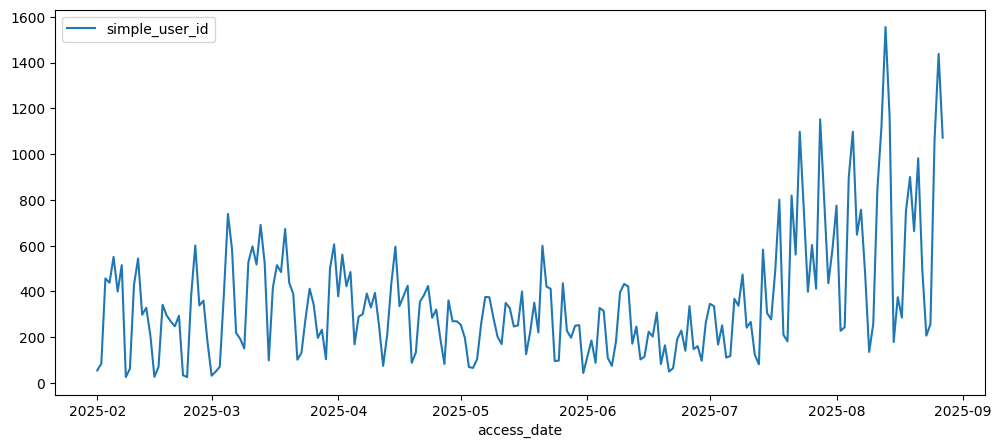

In [153]:
resultdf.groupby(['access_date']).agg({'simple_user_id':'count'}).plot(figsize=(12,5))

In [16]:
pd.resultdf['access_date']

34775     2025-02-10
34776     2025-02-10
34777     2025-02-10
34778     2025-02-10
34779     2025-02-10
             ...    
163615    2025-08-27
163710    2025-08-27
163711    2025-08-27
163794    2025-08-27
163795    2025-08-27
Name: access_date, Length: 75085, dtype: object

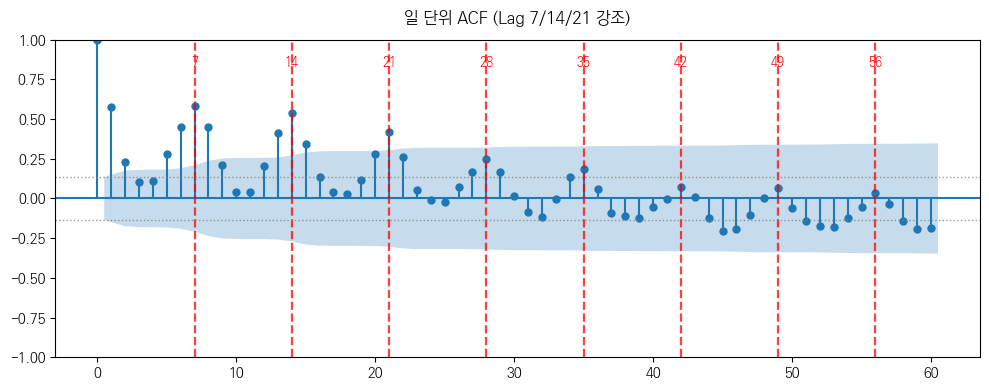

=== ACF 값 (Lag 0 ~ 60) ===
Lag  0:  1.0000
Lag  1:  0.5757
Lag  2:  0.2268
Lag  3:  0.1043
Lag  4:  0.1096
Lag  5:  0.2770
Lag  6:  0.4471
Lag  7:  0.5798  <== 주기 후보
Lag  8:  0.4499
Lag  9:  0.2130
Lag 10:  0.0402
Lag 11:  0.0408
Lag 12:  0.2039
Lag 13:  0.4146
Lag 14:  0.5375  <== 주기 후보
Lag 15:  0.3433
Lag 16:  0.1342
Lag 17:  0.0419
Lag 18:  0.0271
Lag 19:  0.1159
Lag 20:  0.2828
Lag 21:  0.4191  <== 주기 후보
Lag 22:  0.2595
Lag 23:  0.0530
Lag 24: -0.0087
Lag 25: -0.0226
Lag 26:  0.0736
Lag 27:  0.1676
Lag 28:  0.2509  <== 주기 후보
Lag 29:  0.1664
Lag 30:  0.0145
Lag 31: -0.0839
Lag 32: -0.1172
Lag 33: -0.0003
Lag 34:  0.1337
Lag 35:  0.1880  <== 주기 후보
Lag 36:  0.0618
Lag 37: -0.0921
Lag 38: -0.1104
Lag 39: -0.1251
Lag 40: -0.0549
Lag 41: -0.0010
Lag 42:  0.0729  <== 주기 후보
Lag 43:  0.0101
Lag 44: -0.1226
Lag 45: -0.2019
Lag 46: -0.1908
Lag 47: -0.1038
Lag 48:  0.0001
Lag 49:  0.0644  <== 주기 후보
Lag 50: -0.0629
Lag 51: -0.1445
Lag 52: -0.1751
Lag 53: -0.1826
Lag 54: -0.1199
Lag 55: -0.0559


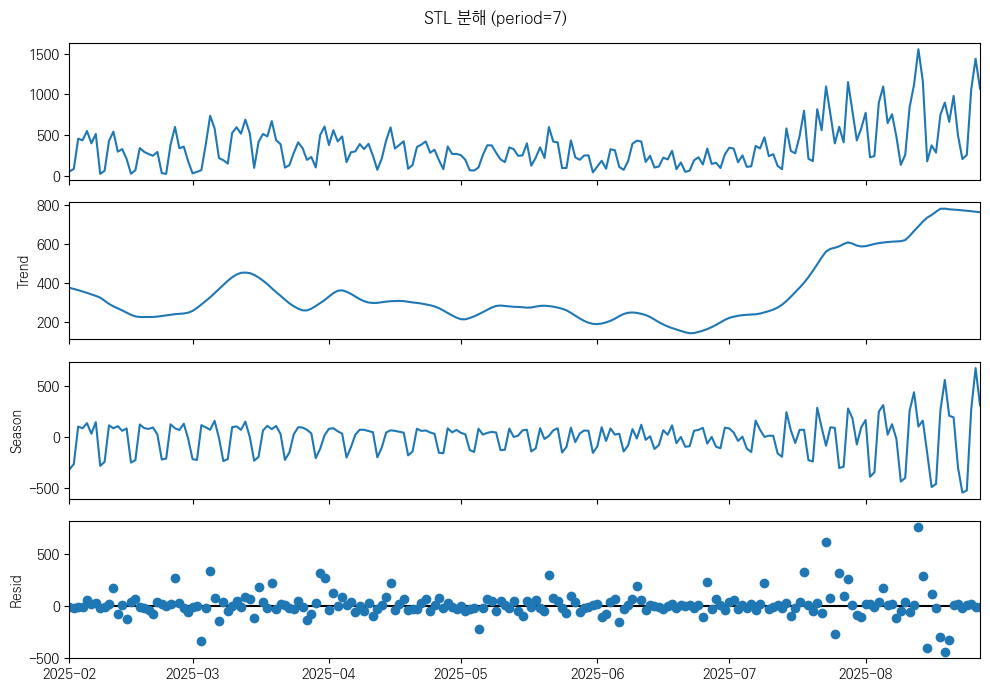

In [30]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL

# access_dt를 datetime으로 변환
resultdf['access_dt'] = pd.to_datetime(resultdf['access_dt'])
ts = (
    df.set_index('access_dt')
      .resample('1D')
      .size()
      .astype(float)  # statsmodels 호환
)

# 참고: 기간이 너무 짧으면(예: 10일 미만) ACF/계절성 신뢰도가 낮을 수 있음
n = len(ts)
if n < 10:
    print(f"[경고] 관측치가 {n}일로 매우 짧습니다. 주(7일) 단위 계절성 해석에 주의하세요.")

# 2) ACF 수치 계산 (최대 60일 또는 n-1 중 작은 값까지)
max_lag = max(1, min(60, n - 1))
acf_vals = acf(ts, nlags=max_lag, fft=True)

# 95% 신뢰구간(대략) 계산
conf_95 = 1.96 / np.sqrt(n)

# 3) ACF 그래프 + Lag 7/14/21 세로선 표시
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(ts, lags=max_lag, ax=ax)
ax.set_title("일 단위 ACF (Lag 7/14/21 강조)", pad=12)

highlight_lags = [x*7 for x in range(1,10)]
for L in highlight_lags:
    if L <= max_lag:
        ax.axvline(L, linestyle='--', linewidth=1.6, color='red', alpha=0.75)
        # 보조 라벨
        ax.text(L, ax.get_ylim()[1]*0.9, f"{L}", ha='center', va='top', fontsize=9, color='red')

# 신뢰구간(±conf_95) 기준선 시각적 보조선(선택 사항)
ax.axhline(conf_95, linestyle=':', linewidth=1.0, color='gray', alpha=0.8)
ax.axhline(-conf_95, linestyle=':', linewidth=1.0, color='gray', alpha=0.8)

plt.tight_layout()
plt.show()

# 4) ACF 수치 표 출력 (전체 + 7/14/21 강조)
print("=== ACF 값 (Lag 0 ~ {0}) ===".format(max_lag))
for lag, val in enumerate(acf_vals):
    mark = "  <== 주기 후보" if lag in highlight_lags else ""
    print(f"Lag {lag:2d}: {val: .4f}{mark}")
print(f"\n95% 신뢰구간(대략): ±{conf_95:.3f}  -> |ACF| > {conf_95:.3f} 이면 유의 가능성")

# 5) STL 분해 (주기=7 가정, 주 단위 계절성 확인)
#    주기가 다를 수 있으면 period를 조정하세요(예: 5, 6, 7, 14 등 탐색)
period = 7
if n < 2*period + 1:
    print(f"[안내] STL은 period={period} 기준으로 충분한 길이(권장 2*period+1 이상)가 필요합니다. 현재 n={n}.")
stl = STL(ts, period=period, robust=True)
res = stl.fit()

# STL 결과 플롯
fig2 = res.plot()
fig2.set_size_inches(10, 7)
fig2.suptitle(f"STL 분해 (period={period})", y=0.98)
plt.tight_layout()
plt.show()


In [40]:
import cudf
import pandas as pd

# pandas 데이터프레임 생성
pdf = pd.DataFrame({
    'a': [1, 2, 3, 4, 5],
    'b': [10, 20, 30, 40, 50]
})

# pandas 데이터프레임을 cuDF 데이터프레임으로 변환
gdf = cudf.DataFrame.from_pandas(pdf)

# 데이터 연산
gdf['c'] = gdf['a'] + gdf['b']

print(gdf)

RuntimeError: Failed to dlopen libcudart.so.12

/tmp/ipykernel_1779466/622653078.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1779466/622653078.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1779466/622653078.py:42: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



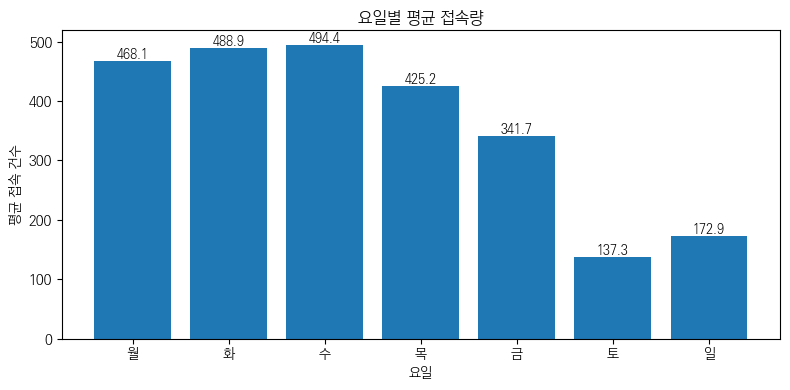

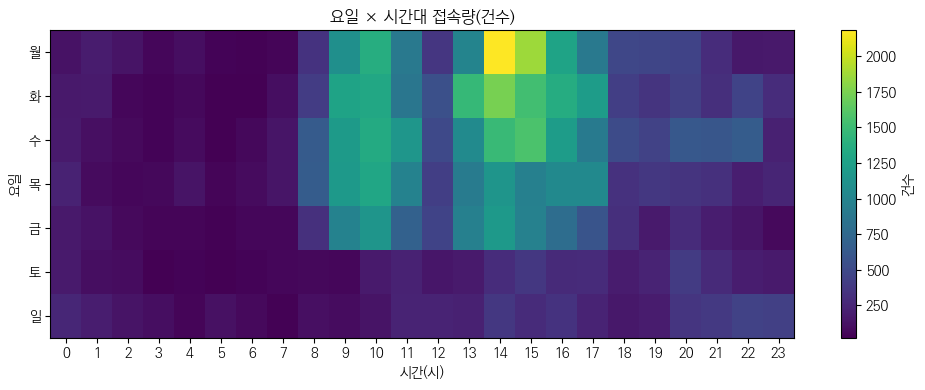

In [39]:
try:
    from scipy.stats import f_oneway
    HAS_SCIPY = True
except Exception:
    HAS_SCIPY = False
# -----------------------------
# 1) 일 단위 집계 및 요일 컬럼
# -----------------------------
# 일 단위 접속 건수
daily = (
    df.set_index('access_dt')
      .resample('1D')
      .size()
      .rename('count')
      .astype(float)
      .to_frame()
      .reset_index()
)

# 요일: 0=월, ..., 6=일
daily['weekday_num'] = daily['access_dt'].dt.dayofweek
weekday_order = [0,1,2,3,4,5,6]
weekday_map_kr = {0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'}
daily['weekday'] = daily['weekday_num'].map(weekday_map_kr)

# -----------------------------
# 2) 요일별 평균 접속량
# -----------------------------
weekday_mean = (
    daily.groupby('weekday_num', as_index=False)['count']
         .mean()
         .sort_values('weekday_num')
)
weekday_mean['weekday'] = weekday_mean['weekday_num'].map(weekday_map_kr)
weekday_mean = weekday_mean[['weekday_num', 'weekday', 'count']].rename(columns={'count':'mean_count'})

# -----------------------------
# 3) 요일×시간대 피벗 (행:요일, 열:0~23시)
# -----------------------------
df['weekday_num'] = df['access_dt'].dt.dayofweek
df['weekday'] = df['weekday_num'].map(weekday_map_kr)
df['hour'] = df['access_dt'].dt.hour

pivot = (
    df.groupby(['weekday_num','hour'])
      .size()
      .unstack(fill_value=0)
      .reindex(index=weekday_order)
)
pivot.index = [weekday_map_kr[i] for i in pivot.index]  # 인덱스 한글화 (월~일)

# -----------------------------
# 4) (선택) 요일별 평균 차이 ANOVA
# -----------------------------
anova_summary = {'available': False}
if HAS_SCIPY:
    # 요일별로 2일 이상 데이터가 있는 그룹만 사용
    groups = []
    valid_weekdays = []
    for w in weekday_order:
        g = daily.loc[daily['weekday_num']==w, 'count'].dropna().values
        if len(g) >= 2:
            groups.append(g)
            valid_weekdays.append(weekday_map_kr[w])
    if len(groups) >= 2:
        F, p = f_oneway(*groups)
        anova_summary = {
            'available': True,
            'k_groups': len(groups),
            'weekdays_tested': valid_weekdays,
            'F_statistic': float(F),
            'p_value': float(p)
        }
    else:
        anova_summary = {
            'available': False,
            'reason': '각 요일별로 최소 2일 이상의 표본이 필요합니다.'
        }

# -----------------------------
# 5) 시각화
# -----------------------------
plt.figure(figsize=(8,4))
plt.bar(weekday_mean['weekday'], weekday_mean['mean_count'])
plt.title('요일별 평균 접속량')
plt.xlabel('요일')
plt.ylabel('평균 접속 건수')
for x, y in zip(weekday_mean['weekday'], weekday_mean['mean_count']):
    plt.text(x, y, f"{y:.1f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.imshow(pivot.values, aspect='auto')
plt.title('요일 × 시간대 접속량(건수)')
plt.xlabel('시간(시)')
plt.ylabel('요일')
plt.xticks(ticks=np.arange(0,24,1), labels=[str(h) for h in range(24)], rotation=0)
plt.yticks(ticks=np.arange(len(pivot.index)), labels=list(pivot.index))
cbar = plt.colorbar()
cbar.set_label('건수')
plt.tight_layout()
plt.show()

In [37]:
resultdf[resultdf['access_dt']>='2025-08-01'].drop(columns=['simple_user_id','access_dt','first_access_dt','session_retention_seconds']).drop_duplicates()

,service,menu,menu_id,access_date
137413,public,홈,id-02-00,2025-08-01
137415,public,인구생활 > 인구 > 인구,20ee7e8c-1c88-4806-ac58-3996dca6e1ab,2025-08-01
137417,public,인구생활 > 인구 > 가구,3e673f6d-822b-4143-b5b1-b919c8826ff6,2025-08-01
137419,public,인구생활 > 인구 > 외국인,76c1e655-17ce-47da-9423-6de1c8b4d373,2025-08-01
137421,public,인구생활 > 보건 > 건강실천,c7134f41-a2e2-44fa-9abf-d2022df44555,2025-08-01
...,...,...,...,...
163232,public,통계조사 > 수원통계DB > 수원기본통계 > 사업체,178da727-af30-4a95-b016-4c7ea0ac3745,2025-08-27
163303,public,데이터지도 > 통계지리정보,fe3e7bbf-dd83-481e-be7b-fa8c857cb352,2025-08-27
163313,public,통계조사 > 수원통계 > 산업경제,trans_id-01-05,2025-08-27
163315,public,통계조사 > 수원통계 > 문화관광,trans_id-01-10,2025-08-27


In [128]:
resultdf.groupby('menu',as_index=False).agg({'session_retention_seconds':'mean','menu_id':'count'}).sort_values('session_retention_seconds',ascending=False).query('menu_id >= 10').head(50)

,menu,session_retention_seconds,menu_id
27,인구생활 > 복지 > 국민건강보험 적용인구,522.337640,50
78,통계조사 > 수원통계DB > 전통시장 및 상점가조사,418.104652,89
80,통계조사 > 통계조사보고서,298.754892,1267
0,데이터지도 > 통계지리정보,284.391420,578
32,인구생활 > 복지 > 노인교실,238.586250,60
70,통계조사 > 수원통계DB > 수원기본통계 > 인구,237.663226,807
76,통계조사 > 수원통계DB > 수원시 사회조사,222.343695,377
14,이용안내 > 공지사항,222.028591,291
52,통계조사 > 수원통계 > 복지,214.081427,656
55,통계조사 > 수원통계 > 인구,208.796663,1876


In [130]:
resultdf['menu'].value_counts().head(50)

menu
홈                                       20289
데이터활용 > 시각화현황                           13259
인구생활 > 인구 > 인구                           4586
통계조사 > 수원통계 > 토지및기후                      4009
통계조사 > 수원통계DB > 수원기본통계 > 토지 및 기후         2532
통계조사 > 수원통계 > 인구                         1876
데이터활용 > 분석보고서                            1851
통계조사 > 통계조사보고서                           1267
인구생활 > 복지 > 국민기초생활보장수급자                  1108
인구생활 > 보건 > 건강실천                         1096
도시환경 > 토지및기후 > 토지                         993
인구생활 > 문화 > 문화인프라                         922
행정경제 > 행정 > 공무원 정원                        883
도시환경 > 교통 > 교통인프라                         879
인구생활 > 인구 > 가구                            812
통계조사 > 수원통계DB > 수원기본통계 > 인구               807
행정경제 > 경제 > 지역경제                          785
도시환경 > 환경 > 대기와에너지                        750
통계조사 > 수원통계 > 복지                          656
도시환경 > 주거 > 주택공급                          589
데이터지도 > 통계지리정보                            578
인구생활 > 교육 > 교육기관             